In [1]:
import pandas as pd

In [2]:
users_df = pd.read_csv("data/Users.csv")
comments_df = pd.read_csv("data/Comments.csv")
postHistory_df = pd.read_csv("data/PostHistory.csv")
badges_df = pd.read_csv("data/Badges.csv")

# clean users_df
users_df.drop(["Location", "Views", "UpVotes", "WebsiteUrl", "EmailHash", "AboutMe", "DownVotes", "ProfileImageUrl"], inplace=True, axis=1)

# num posts
numPosts_df = postHistory_df.groupby("UserId").size()

# add in numPosts to each user
for id, numPosts in numPosts_df.items():
    if id == "UserId": continue
    id = int(id)
    users_df.loc[users_df["Id"] == id, "NumPosts"] = numPosts


In [3]:
users_df.head(10)

,Id,Reputation,CreationDate,DisplayName,LastAccessDate,AccountId,NumPosts
0,237137,36,1261512223193,davrous,1262209129173,580584,1.0
1,907595,13,1314098270493,René,1316454773330,799199,6.0
2,1869230,435,1354389119783,dan1,1533455867923,2101798,13.0
3,1861431,75,1354139880027,Bryan,1426906926187,2091763,27.0
4,1858121,11,1354057590997,RubenatoR,1372184147920,2087541,3.0
5,1853324,9,1353932012327,d2h,1364545684757,2081415,3.0
6,1846334,141,1353631826510,Lewis Boyles-White,1514998297073,2072099,41.0
7,1836532,21,1353345932493,Mohsen Alizadeh,1551785455310,2059610,14.0
8,1966854,3,1357824395260,labworxsa,1607685254290,2228670,5.0
9,1833626,21,1353247966420,Almar Klein,1353267074797,2055834,1.0


In [4]:
reps = 0
for user in users_df.iterrows():
    reps += user[1]['Reputation']

avg_sample_rep = reps/users_df.shape[0]    

print(f"Average Sample Reputation: {round(avg_sample_rep, 2)}")

Average Sample Reputation: 236.14


In [5]:
len(users_df.index)

2500

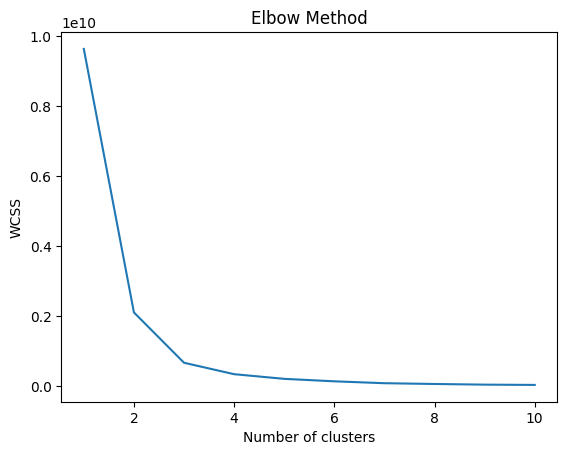

In [6]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

X = users_df[["Reputation", "NumPosts"]].values


wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


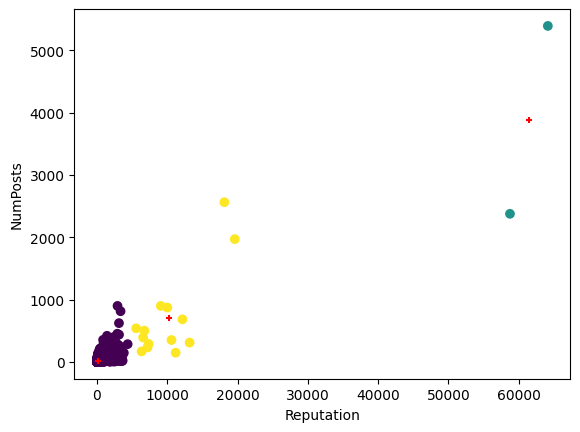

,Reputation,NumPosts
0,130.299114,16.471417
2,10270.428571,709.214286
1,61452.000000,3882.500000


In [7]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# k-means with reputation and numposts
data = users_df[['Reputation', 'NumPosts']].values

kmeans = KMeans(n_clusters=3)
kmeans.fit(data)

labels = kmeans.labels_
users_df['Cluster'] = labels

labels = kmeans.labels_
centers = kmeans.cluster_centers_

# scatter plot dis bih
plt.scatter(data[:, 0], data[:, 1], c=labels)

# plot center of each group
plt.scatter(centers[:, 0], centers[:, 1], marker='+', s=25, color='red')

plt.xlabel('Reputation')
plt.ylabel('NumPosts')
plt.show()


analysis_df = pd.DataFrame(columns=["Reputation", "NumPosts"])

for label in set(labels):
    cluster = users_df[users_df['Cluster'] == label]
    new_row = pd.DataFrame([{'Reputation': cluster["Reputation"].mean(), 'NumPosts': cluster["NumPosts"].mean()}])
    analysis_df = pd.concat([analysis_df, new_row], ignore_index=True)

analysis_df.sort_values("Reputation", ascending=True).head(20)
